<a href="https://colab.research.google.com/github/clovisdanielss/Colab-Projects/blob/main/sentiment-prediction/Review_Sentiment_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### NLP Example

In this notebook we'll experiment and train a NLP model to predict sentiment of products reviews.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
dataset = pd.read_csv('https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P')
dataset.head()

,Unnamed: 0,text,sentiment
0,0,So there is no way for me to plug it in here i...,0
1,1,Good case Excellent value.,1
2,2,Great for the jawbone.,1
3,3,Tied to charger for conversations lasting more...,0
4,4,The mic is great.,1


In [8]:
dataset.text

0       So there is no way for me to plug it in here i...
1                              Good case Excellent value.
2                                  Great for the jawbone.
3       Tied to charger for conversations lasting more...
4                                       The mic is great.
                              ...                        
1987    I think food should have flavor and texture an...
1988                             Appetite instantly gone.
1989    Overall I was not impressed and would not go b...
1990    The whole experience was underwhelming and I t...
1991    Then as if I hadn't wasted enough of my life t...
Name: text, Length: 1992, dtype: object

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset.text)
len(tokenizer.word_index)

3260

In [14]:
sequences = tokenizer.texts_to_sequences(dataset.text)
padded = pad_sequences(sequences)
padded

array([[   0,    0,    0, ...,  112,    4, 1428],
       [   0,    0,    0, ...,  109,   86,  396],
       [   0,    0,    0, ...,   12,    1,  731],
       ...,
       [   0,    0,    0, ...,   11,   59,   39],
       [   0,    0,    0, ...,  245,  242,   38],
       [   0,    0,    0, ...,  604,    1,  374]], dtype=int32)

In [19]:
tf.random.set_seed(42)
batch_size = 32
train = tf.data.Dataset.from_tensor_slices((padded, dataset.sentiment.to_numpy())).batch(batch_size)

In [25]:
len(list(train)),len(list(train))*batch_size,dataset.text.to_numpy().shape

(63, 2016, (1992,))

Let's check how a simple nlp model behaves without any data preparation. 

#### Our first model

In [43]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(len(tokenizer.word_index)+1,64,input_length=padded.shape[1]),
        tf.keras.layers.SimpleRNN(64),
        tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
stop = tf.keras.callbacks.EarlyStopping(patience = 5, monitor="loss")

model.fit(train, epochs=10, callbacks=[stop])

Epoch 1/10
63/63 [==============================] - 5s 55ms/step - loss: 0.6872 - accuracy: 0.5447
Epoch 2/10
63/63 [==============================] - 2s 38ms/step - loss: 0.5538 - accuracy: 0.7600
Epoch 3/10
63/63 [==============================] - 2s 38ms/step - loss: 0.4265 - accuracy: 0.8318
Epoch 4/10
63/63 [==============================] - 2s 38ms/step - loss: 0.1616 - accuracy: 0.9769
Epoch 5/10
63/63 [==============================] - 2s 38ms/step - loss: 0.0635 - accuracy: 0.9935
Epoch 6/10
63/63 [==============================] - 2s 39ms/step - loss: 0.0354 - accuracy: 0.9980
Epoch 7/10
63/63 [==============================] - 2s 38ms/step - loss: 0.0190 - accuracy: 0.9990
Epoch 8/10
63/63 [==============================] - 2s 38ms/step - loss: 0.0125 - accuracy: 1.0000
Epoch 9/10
63/63 [==============================] - 2s 38ms/step - loss: 0.0085 - accuracy: 1.0000
Epoch 10/10
63/63 [==============================] - 2s 39ms/step - loss: 0.2766 - accuracy: 0.8810


In [50]:
def predict(text):
  seq = tokenizer.texts_to_sequences([text])
  pad = pad_sequences(seq, padded.shape[1])
  pred = model.predict(pad)
  return pred

predict("I did NOT like your product")

array([[0.24529558]], dtype=float32)

Our first model seems to be fine. But It's most like overfitting. We will now split our data to check it.

In [53]:
tf.random.set_seed(42)
batch_size = 32
data_size = dataset.text.to_numpy().shape[0]
test_size = math.ceil(data_size/5)
train_size = data_size - test_size
data = tf.data.Dataset.from_tensor_slices((padded, dataset.sentiment.to_numpy())).shuffle(1000)
train = data.take(train_size).batch(batch_size)
test = data.skip(train_size).batch(batch_size)

len(list(train)), len(list(test))

(50, 13)

In [56]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(len(tokenizer.word_index)+1,64,input_length=padded.shape[1]),
        tf.keras.layers.SimpleRNN(64),
        tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
stop = tf.keras.callbacks.EarlyStopping(patience = 5)
best = tf.keras.callbacks.ModelCheckpoint("best.h5", save_only_best=True)

log = model.fit(train,validation_data=test, epochs=10, callbacks=[stop, best])

Epoch 1/10
50/50 [==============================] - 6s 85ms/step - loss: 0.6897 - accuracy: 0.5223 - val_loss: 0.6243 - val_accuracy: 0.7744
Epoch 2/10
50/50 [==============================] - 4s 82ms/step - loss: 0.5669 - accuracy: 0.7615 - val_loss: 0.4151 - val_accuracy: 0.8346
Epoch 3/10
50/50 [==============================] - 4s 78ms/step - loss: 0.3198 - accuracy: 0.8977 - val_loss: 0.2044 - val_accuracy: 0.9574
Epoch 4/10
50/50 [==============================] - 4s 80ms/step - loss: 0.1553 - accuracy: 0.9648 - val_loss: 0.1198 - val_accuracy: 0.9749
Epoch 5/10
50/50 [==============================] - 4s 73ms/step - loss: 0.1034 - accuracy: 0.9774 - val_loss: 0.0568 - val_accuracy: 0.9925
Epoch 6/10
50/50 [==============================] - 2s 42ms/step - loss: 0.0443 - accuracy: 0.9937 - val_loss: 0.0371 - val_accuracy: 0.9925
Epoch 7/10
50/50 [==============================] - 2s 43ms/step - loss: 0.0307 - accuracy: 0.9918 - val_loss: 0.0275 - val_accuracy: 0.9950
Epoch 8/10
50

In [55]:
predict("Wow, this is amazing")

array([[0.9976537]], dtype=float32)

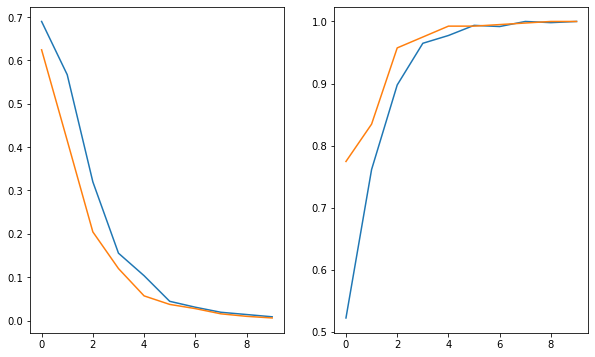

In [57]:
def plot_training():
  epochs = len(log.history["loss"])
  plt.figure(figsize=(10,6))
  plt.subplot(1,2,1)
  plt.plot(range(epochs), log.history["loss"])
  plt.plot(range(epochs), log.history["val_loss"])
  plt.subplot(1,2,2)
  plt.plot(range(epochs), log.history["accuracy"])
  plt.plot(range(epochs), log.history["val_accuracy"])

plot_training()

Ok, It's not overfitting. But there are two things to say. 

- The dataset is too small. We just have 2000 phrases. This is way to little. 
- We know all the words in the test set. This will never happen.

So if we want to make a more real experimentation, let's try limit our word_index

In [58]:
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(dataset.text)
sequences = tokenizer.texts_to_sequences(dataset.text)
padded = pad_sequences(sequences)
padded

array([[   0,    0,    0, ...,  112,    4, 1428],
       [   0,    0,    0, ...,  109,   86,  396],
       [   0,    0,    0, ...,   12,    1,  731],
       ...,
       [   0,    0,    0, ...,   11,   59,   39],
       [   0,    0,    0, ...,  245,  242,   38],
       [   0,    0,    0, ...,  604,    1,  374]], dtype=int32)

Now, we only know $\frac{2}{3}$ of the words in our dataset

In [60]:
tf.random.set_seed(42)
batch_size = 32
data_size = dataset.text.to_numpy().shape[0]
test_size = math.ceil(data_size/5)
train_size = data_size - test_size
data = tf.data.Dataset.from_tensor_slices((padded, dataset.sentiment.to_numpy())).shuffle(1000)
train = data.take(train_size).batch(batch_size)
test = data.skip(train_size).batch(batch_size)

len(list(train)), len(list(test))

(50, 13)

Epoch 1/10
50/50 [==============================] - 5s 48ms/step - loss: 0.6928 - accuracy: 0.5204 - val_loss: 0.6422 - val_accuracy: 0.6291
Epoch 2/10
50/50 [==============================] - 2s 34ms/step - loss: 0.5705 - accuracy: 0.7847 - val_loss: 0.3975 - val_accuracy: 0.9048
Epoch 3/10
50/50 [==============================] - 2s 34ms/step - loss: 0.3682 - accuracy: 0.8726 - val_loss: 0.2576 - val_accuracy: 0.9348
Epoch 4/10
50/50 [==============================] - 2s 34ms/step - loss: 0.2383 - accuracy: 0.9178 - val_loss: 0.2285 - val_accuracy: 0.9123
Epoch 5/10
50/50 [==============================] - 2s 34ms/step - loss: 0.1574 - accuracy: 0.9630 - val_loss: 0.0971 - val_accuracy: 0.9850
Epoch 6/10
50/50 [==============================] - 2s 34ms/step - loss: 0.0803 - accuracy: 0.9849 - val_loss: 0.0567 - val_accuracy: 0.9950
Epoch 7/10
50/50 [==============================] - 2s 34ms/step - loss: 0.0446 - accuracy: 0.9944 - val_loss: 0.0263 - val_accuracy: 0.9975
Epoch 8/10
50

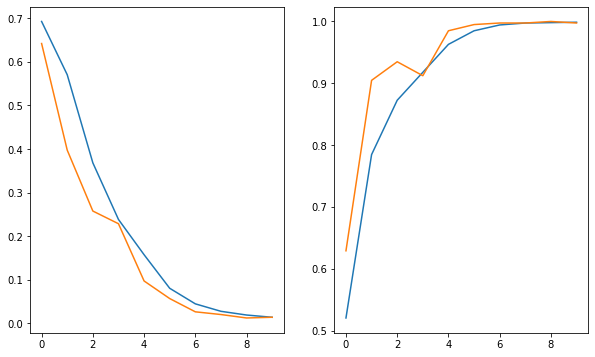

In [61]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(len(tokenizer.word_index)+1,64,input_length=padded.shape[1]),
        tf.keras.layers.SimpleRNN(64),
        tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
stop = tf.keras.callbacks.EarlyStopping(patience = 5)
best = tf.keras.callbacks.ModelCheckpoint("best.h5", save_only_best=True)

log = model.fit(train,validation_data=test, epochs=10, callbacks=[stop, best])
plot_training()

Even knowing only $\frac{2}{3}$ of our words, the results seems promissing. Lets check our words.

In [73]:
ordered_by_freq = [(key,val) for key,val in tokenizer.word_counts.items()]
ordered_by_freq.sort(key=lambda tup: tup[1], reverse=True)
ordered_by_freq[:20]

[('the', 1104),
 ('and', 704),
 ('i', 627),
 ('a', 456),
 ('it', 418),
 ('to', 417),
 ('is', 414),
 ('was', 385),
 ('this', 351),
 ('of', 247),
 ('not', 233),
 ('for', 231),
 ('my', 218),
 ('in', 197),
 ('with', 183),
 ('very', 180),
 ('good', 172),
 ('great', 169),
 ('phone', 165),
 ('that', 148)]

As we know, we didn't make any data preparation. So a lot of words are stop words. But as we can see, we can identify words such as:

- not
- very
- good
- great

Those words capture the essence of a good review or a bad review. If the model was still going bad, here is a couple things we could do:

- Remove stopwords from vocabulary
- Use subwords in tokenization
- Tweek the model

### Conclusion

This dataset didnt need any kind of data preparation, so It was very simple to work with it. Since we got a model working with 1.0 of accuracy in the validation data, I will call it a day and work in another dataset.

In [77]:
!pip install tensorflowjs
!tensorflowjs_converter --input_format keras best.h5 ./predictor/
from google.colab import files
files.download("predictor/group1-shard1of1.bin")
files.download("predictor/model.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>